In [1]:
import numpy as np
import pandas as pd
import os
import glob
import h5py
import wandb

import string
import random

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint


from torch import optim, utils, Tensor

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import sklearn.linear_model


from itables import show
from src.model.SimpleMILModels import Attention, MaxMIL, AttentionResNet
from src.dataloaders.DataLoaders import RetCCLFeatureLoader, RetCCLFeatureLoaderMem


import zarr
import seaborn as sns

recompute_attn = False

In [2]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [3]:


import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"


In [4]:
group = "WO3OUI"

In [5]:

api = wandb.Api()


In [6]:
runs = api.runs(path="psmirnov/UKHD_RetCLL_299_CT", filters={"group": group})

In [7]:
runs

<Runs psmirnov/UKHD_RetCLL_299_CT>

Load in the features (not too much memory needed)

In [8]:
path_to_extracted_features = '/omics/odcf/analysis/OE0585_projects/chromothripsis/histopathology/TCGA/ffpe/UNI'

In [9]:
slide_meta = pd.read_csv("../metadata/tcga_labeled_data.csv")


In [10]:
(slide_meta.project == "LGG").sum()


55

In [11]:
slide_meta[(slide_meta.project=="LGG") | (slide_meta.project=="GBM")]

,Unnamed: 0.1,Unnamed: 0,CT_Status,TCGA_Case,0,project,PatientID,slide_id,patches,labels
1,2,/omics/groups/OE0585/internal/p163v/TCGA_downl...,No Chromothripsis,TCGA-02-0003,TCGA-02-0003-01Z-00-DX1.6171b175-0972-4e84-999...,GBM,TCGA-02-0003,TCGA-02-0003-01Z-00-DX1,11146,0
2,3,/omics/groups/OE0585/internal/p163v/TCGA_downl...,No Chromothripsis,TCGA-02-0003,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-825...,GBM,TCGA-02-0003,TCGA-02-0003-01Z-00-DX2,8501,0
3,4,/omics/groups/OE0585/internal/p163v/TCGA_downl...,No Chromothripsis,TCGA-02-0003,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A...,GBM,TCGA-02-0003,TCGA-02-0003-01Z-00-DX3,2998,0
26,89,/omics/groups/OE0585/internal/p163v/TCGA_downl...,Chromothripsis,TCGA-06-0129,TCGA-06-0129-01Z-00-DX1.b7bddf7d-f39e-45e7-a78...,GBM,TCGA-06-0129,TCGA-06-0129-01Z-00-DX1,1291,1
27,90,/omics/groups/OE0585/internal/p163v/TCGA_downl...,Chromothripsis,TCGA-06-0129,TCGA-06-0129-01Z-00-DX2.1ea78b46-1dc7-44d8-81b...,GBM,TCGA-06-0129,TCGA-06-0129-01Z-00-DX2,208,1
...,...,...,...,...,...,...,...,...,...,...
3069,12247,/omics/groups/OE0585/internal/p163v/TCGA_downl...,Chromothripsis,TCGA-12-3651,TCGA-12-3651-01Z-00-DX4.CCABF491-326A-42B1-B10...,GBM,TCGA-12-3651,TCGA-12-3651-01Z-00-DX4,15064,1
3089,12318,/omics/groups/OE0585/internal/p163v/TCGA_downl...,No Chromothripsis,TCGA-02-0054,TCGA-02-0054-01Z-00-DX1.B8AFCEF2-4ED1-4329-854...,GBM,TCGA-02-0054,TCGA-02-0054-01Z-00-DX1,4555,0
3129,12493,/omics/groups/OE0585/internal/p163v/TCGA_downl...,No Chromothripsis,TCGA-FG-A4MY,TCGA-FG-A4MY-01Z-00-DX1.EB81EFA3-9B05-4480-857...,LGG,TCGA-FG-A4MY,TCGA-FG-A4MY-01Z-00-DX1,1608,0
3141,12531,/omics/groups/OE0585/internal/p163v/TCGA_downl...,No Chromothripsis,TCGA-14-1794,TCGA-14-1794-01Z-00-DX1.90a1497f-3308-4c70-afc...,GBM,TCGA-14-1794,TCGA-14-1794-01Z-00-DX1,1877,0


In [12]:



slide_meta = pd.read_csv("../metadata/tcga_labeled_data.csv")

# 50 random slides

# myx = np.random.choice(np.array(range(len(slide_meta[slide_meta.project=="GBM"].slide_id))), 50)
myx = range(len(slide_meta[(slide_meta.project=="LGG") | (slide_meta.project=="GBM")].slide_id))
gbm_slides = slide_meta[(slide_meta.project=="LGG") | (slide_meta.project=="GBM")].slide_id.iloc[myx]

test_labels = slide_meta[(slide_meta.project=="LGG") | (slide_meta.project=="GBM")].labels.iloc[myx]

#all_files = [x for x in slide_annots.file if os.path.isfile(path_to_extracted_features + "/" + x)]
#    all_features = {file: h5py.File(path_to_extracted_features + "/" + file, 'r')['feats'][:] for file in all_files}

In [13]:
test_labels.mean()

0.6

In [14]:
test_labels.__len__()

300

In [15]:

# def zarr_loader(path, i, extra_features=None):
#     root = zarr.open(path, "r")
#     x = root['features'][:]
#     return x

In [18]:
gbm_slides

1       TCGA-02-0003-01Z-00-DX1
2       TCGA-02-0003-01Z-00-DX2
3       TCGA-02-0003-01Z-00-DX3
26      TCGA-06-0129-01Z-00-DX1
27      TCGA-06-0129-01Z-00-DX2
                 ...           
3069    TCGA-12-3651-01Z-00-DX4
3089    TCGA-02-0054-01Z-00-DX1
3129    TCGA-FG-A4MY-01Z-00-DX1
3141    TCGA-14-1794-01Z-00-DX1
3142    TCGA-14-1794-01Z-00-DX2
Name: slide_id, Length: 300, dtype: object

In [19]:
test_features = [zarr.open(path_to_extracted_features + "/" + file + "_uni_embedding.zarr", 'r')['features'][:] for file in gbm_slides]

# Loss

We use the loss as the early stopping criteria


In [20]:
model_list = list()
attention_list = list()
prob_list = list()
pred_list = list()
cv =  lambda x: np.std(x) / np.mean(x)

In [21]:
test_data = RetCCLFeatureLoaderMem(test_features, np.array(test_labels), patches_per_iter='all')

RetCCLTest = DataLoader(test_data, batch_size=1, num_workers=1)#, sampler=valid_Sampler)


In [24]:
for ii in range(len(runs)):
    
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version).split('-')[0]: a for a in arts}
    checkpoint_folder_name = arts_dict['model'].name.split('-')[1].removesuffix(':'+arts_dict['model'].version)
    args = runs[0].config

    model = Attention(1024, lr=args['lr'], weight_decay=args['weight_decay'], hidden_dim=args['hidden_dim'], attention_dim=args['attention_dim'], class_weights=torch.tensor(float(args['class_weights'])))
    chkpt_file = glob.glob('lightning_logs/'+checkpoint_folder_name+'/checkpoints/best_loss*')[0]
    model = model.load_from_checkpoint(chkpt_file, map_location=torch.device('cpu'))
    model.eval()
    model_list.append(model)
    model_forward = [model.forward(x.to(model.device)) for x,y in iter(RetCCLTest)]
    model_attention = [x[2].detach().numpy() for x in model_forward]
    model_prob = [x[0].detach().numpy() for x in model_forward]
    model_pred = [x[1].detach().numpy() for x in model_forward]

    attention_list.append(model_attention)
    prob_list.append(model_prob)
    pred_list.append(model_pred)
    

In [25]:
prob_list = [np.concatenate(x) for x in prob_list]
pred_list = [np.concatenate(x) for x in pred_list]


In [26]:
prob_test = np.mean(np.vstack(prob_list), axis=0)

In [27]:
prob_test = np.mean(np.vstack([sigmoid_array(x) for x in prob_list]), axis=0)





ValueError: Found input variables with inconsistent numbers of samples: [300, 5]

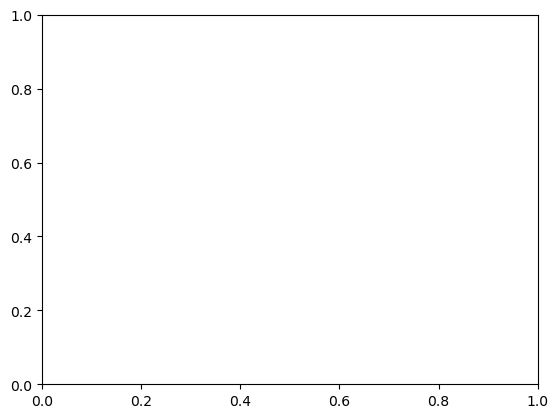

In [29]:


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    np.array(test_labels),
    prob_test,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.savefig("/home/p163v/histopathology/Notebooks/GBM_Validation_ROC_UNI.png")
plt.show()


In [ ]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    np.array(test_labels),
    prob_test,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.savefig("/home/p163v/histopathology/Notebooks/GBM_Validation_AUPR_UNI.png")
plt.show()